In [1]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")
x_smooth, u_smooth, y_smooth , v_smooth = process_data.smooth_trajectories(x_raw,y_raw)

In [2]:
from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
target_points = [ (0,0) , (0,1), (1,1) ]
reference_points = [(0,0) , (0,height) , (width,height)]
x_smooth = map( lambda x: x/width , x_smooth )
u_smooth = map( lambda x: x/width , u_smooth )
y_smooth = map( lambda x: -x/height , y_smooth )
v_smooth = map( lambda x: -x/height , v_smooth )

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

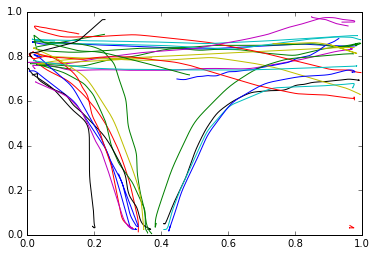

In [4]:
for k in range(len(x_smooth)):
    plt.plot(x_smooth[k],y_smooth[k])

    plt.grid()

(0.0, 1.0, 0.0, 0.90000000000000002)

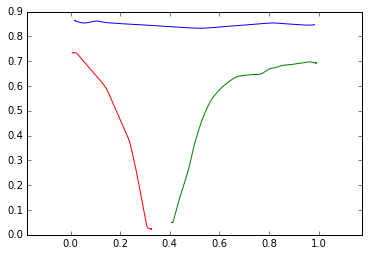

In [5]:
plt.plot(x_smooth[0],y_smooth[0])
plt.plot(x_smooth[6],y_smooth[6])
plt.plot(x_smooth[14],y_smooth[14])
plt.axis('equal')

(0.40000000000000002, 1.0, 0.0, 0.70000000000000007)

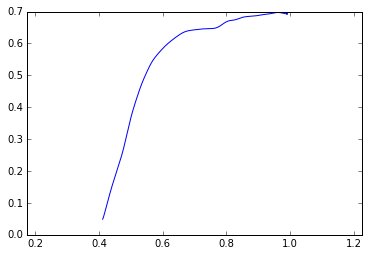

In [6]:
curve = np.zeros((400,2))
curve[:,0] = x_smooth[6][200:600]
curve[:,1] = y_smooth[6][200:600]
plt.plot(curve[:,0], curve[:,1])
plt.axis('equal')

## Cost function
For any two points $x_0,x_T$ we let $x(t;\theta)$ denote the curve on $[0,T]$ which minimizes the action
$$
    S[x;\theta] := \int_0^T L_\theta( x,\dot{x}) dt
$$
In otherwords, $x( \cdot \,;\theta) = {\rm argmin}_y( S[y;\theta] ) $.
Our goal is to learn the parameters, $\theta$.
Given a single curve $X:[0,T]\to D$, the cost function for our learning algorithm will be
$$
    C(\theta) = \frac{1}{2} \int_0^T \| X(t) - x(t;X_0,X_T,\theta) \|^2 dt
$$
so that the gradient is
$$
    dC(\theta) = - \int \langle X(t) - x(t;\theta) , \delta_\theta x(t;\theta) \rangle dt
$$
where $\delta_\theta x(t;\theta)$ solves the boundary value problem
$$
    \ddot{x} = - \nabla V(x;\theta) \quad , \frac{d^2}{dt^2} \delta_\theta x = - \delta_\theta \nabla V(x;\theta) \delta_\theta x
$$
with the boundary conditions $x(0),x(T)$ given and $\delta_\theta x(0) = \delta_\theta x(T) = 0$.

We solve this boundary value problem with a shooting method, using the gradient of the initial condition to help us.  The variation of the initial condition $\delta \partial_\beta q^j_0$ is computed by solving
$$
    \frac{d^2 x^i}{dt^2} + \partial_i V(x) = 0 \\
    \frac{d^2 \partial_\alpha x^i }{dt^2} + \partial_\alpha \partial_i V(x) + \partial_{ik} V(x) \partial_\alpha x^k = 0 \\
    \frac{d^2}{dt^2} \left( \frac{ \delta \partial_\alpha x^i }{ \delta \partial_\beta x^j_0 } \right)
    + \partial_{ik}V(x) \frac{ \delta \partial_\alpha x^k }{\delta \partial_\beta x^j_0 }
$$
where $x^i(0)$ and $\partial_\alpha x^i (0)=0$ are given,
$x^i(1)$ and $\partial_\alpha x^i(1)$ are guessed,
and $\delta \partial_\alpha x^i(0)$ and $\delta \partial_\alpha x^i(1)$ are deduced from the circumstances (the first is zero, the second is sort of an indentity matrix).

In [150]:
max_degree = 2

def potential(q,theta):
    #returns the potential function assuming a trigonometric potential
    #theta = theta.reshape( (2*max_degree+1,2*max_degree+1))
    k_span = np.arange(-max_degree, max_degree+1)
    basis = np.outer( np.exp( 2*np.pi*1j * k_span * q[0] ) , np.exp( 2*np.pi*1j * k_span * q[1] ) )
    return np.einsum( 'ab,ab' , theta, basis )

def force(q,theta):
    #returns the potential force assuming a trigonometric potential
    #theta = theta.reshape( (2*max_degree+1,2*max_degree+1))
    k_span = np.arange(-max_degree, max_degree+1)
    V_x = np.einsum( 'ij,i,j', theta, 2*np.pi*1j*k_span*np.exp( 2*np.pi*1j*k_span*q[0]), np.exp(2*np.pi*1j*k_span*q[1]) )
    V_y = np.einsum( 'ij,i,j', theta, np.exp( 2*np.pi *1j* k_span * q[0] ) , 2*np.pi*1j*k_span * np.exp( 2*np.pi*1j*k_span * q[1] ) )
    return np.array([V_x, V_y])

def force_q(q,theta):
    #returns the spatial gradient of the potential force
    #theta = theta.reshape( (2*max_degree+1,2*max_degree+1))
    k_span = np.arange(-max_degree, max_degree+1)
    V_xx = np.einsum( 'ij,i,j', theta, -4*(np.pi*k_span)**2 *np.exp( 2*np.pi*1j*k_span*q[0]),
                     np.exp(2*np.pi*1j*k_span*q[1]) )
    V_xy = np.einsum( 'ij,i,j', theta, 2*np.pi*1j*k_span*np.exp( 2*np.pi*1j*k_span*q[0]),
                     2*np.pi*1j*k_span*np.exp(2*np.pi*1j*k_span*q[1]) )
    V_yy = np.einsum( 'ij,i,j', theta, np.exp( 2*np.pi*1j*k_span*q[0]),
                     -4*(np.pi*k_span)**2 * np.exp(2*np.pi*1j*k_span*q[1]) )
    return np.array([[V_xx,V_xy],[V_xy,V_yy]])

def force_theta(q,theta):
    #returns the parametric gradient of the potential force
    #theta = theta.reshape( (2*max_degree+1,2*max_degree+1))
    k_span = np.arange(-max_degree, max_degree+1)
    s_x = np.einsum( 'i,j->ij', 2*np.pi*1j*k_span*np.exp( 2*np.pi*1j*k_span*q[0]), np.exp(2*np.pi*1j*k_span*q[1]) )
    s_y = np.einsum( 'i,j->ij', np.exp( 2*np.pi *1j* k_span * q[0] ) , 2*np.pi*1j*k_span * np.exp( 2*np.pi*1j*k_span * q[1] ) )
    return np.array([s_x , s_y ])

def force_q_theta(q,theta):
    #retuns the mixed parametric/spatial gradiant of the potential force
    k_span = np.arange(-max_degree, max_degree+1)
    s_xx = np.einsum( 'i,j->ij', -4*(np.pi*k_span)**2 * np.exp( 2*np.pi*1j*k_span*q[0]), np.exp(2*np.pi*1j*k_span*q[1]) )
    s_yy = np.einsum( 'i,j->ij', np.exp( 2*np.pi *1j* k_span * q[0] ) , -4*(np.pi*k_span)**2 * np.exp( 2*np.pi*1j*k_span * q[1] ) )
    s_xy = np.einsum( 'i,j->ij', 2*np.pi*k_span*1j*np.exp( 2*np.pi*1j*k_span*q[0]), 2*np.pi*1j*k_span*np.exp(2*np.pi*1j*k_span*q[1]) )
    return np.array([[s_xx , s_xy ],[s_xy,s_yy]])
    
print "testing potential and force"
q = np.random.randn(2)
theta = np.random.randn( 2*max_degree+1 , 2*max_degree+1 )
V = potential(q,theta)
dq = np.random.randn(2)*1e-4
V_other = potential(q+dq,theta)
V_q = force(q,theta)
print "error of force = %f" % np.abs(V_other - V - np.dot( V_q , dq ))

V_q_other = force(q+dq,theta)
V_qq = force_q(q+dq,theta)

print "error of force_q = %f" % np.abs( V_q_other - V_q - np.dot( V_qq , dq) ).max()

dtheta = 1e-4*np.random.randn( 2*max_degree+1 , 2*max_degree+1 )
V_q_other = force(q , theta + dtheta)
V_qa = force_theta(q,theta)
print "error of force_theta = %f" % np.abs(V_q_other - V_q - np.einsum( 'iab,ab',V_qa , dtheta )).max()

V_qq = force_q(q,theta)
V_qq_other = force_q( q, theta+dtheta )
V_qqa = force_q_theta(q,theta)
print "error of force_q_theta = %f" % np.abs( V_qq_other - V_qq - np.einsum( 'ijab,ab->ij', V_qqa , dtheta) ).max().max()


testing potential and force
error of force = 0.000000
error of force_q = 0.000001
error of force_theta = 0.000000
error of force_q_theta = 0.000000


In [165]:
par_shape = (2*max_degree+1,2*max_degree+1)
def shoot(q0,q1,theta,N,jac=False):
    #solves the EL equations to time N
    #if jac is True, then computes sensitivity with respect to q1
    q_k0 = q0
    q_k1 = q1
    if jac:
        dq_k0 = np.zeros((2,2))
        dq_k1 = np.eye(2)
    #Integrate trajectory
    for k in range(1,N):
        dV = force(q_k1,theta).real
        if jac:
            d2V = force_q(q_k1,theta.reshape( par_shape) ).real
        q_k2 = 2*q_k1 - q_k0 - dV
        #Now update
        q_k0 = q_k1
        q_k1 = q_k2
        if jac:
            dq_k2 = 2*dq_k1 - dq_k0 - np.einsum('ik,ij',d2V,dq_k1)
            #Now update
            dq_k0 = dq_k1
            dq_k1 = dq_k2
    if jac:
        return q_k1,dq_k1
    return q_k1

print "testing shoot"
q0 = np.random.randn(2)
q1 = q0 + 1e-3*np.random.randn(2)
theta = 0.1*np.random.rand( 2*max_degree+1 , 2*max_degree+1)
N = 5
qN ,dqN= shoot(q0,q1,theta,N,jac=True)
q1_other = q1.copy()
perturbation = 1e-4 * np.random.randn(2)
q1_other += perturbation
qN_other, dqN_other = shoot(q0,q1_other,theta,N,jac=True)

print 0.5 *np.dot(dqN_other + dqN , perturbation) - (qN_other - qN)
print dqN
print dqN_other

testing shoot
[-215.0955979   371.07750436]
[[-1797034.05977675  3488133.73818721]
 [ 2046738.5915379  -3924148.31408125]]
[[   69911.17501213   818625.20174759]
 [ -256701.11501393 -3059058.87045311]]


In [135]:
def shoot_for_sensitivity( q0, q1, s1 , theta, N , jac=False):
    # computes, sN, the partial derivative of qN with respect to theta, given q0,q1 and s1
    # if jac is True then we compute how s_N varies with respect to s1.
    n = 2*max_degree+1 #number of modes along one dimension
    q_k0 = q0
    q_k1 = q1
    s_k0 = np.zeros( (2,n,n) )
    s_k1 = s1.reshape( (2,n,n) )
    if jac:
        ds_k0 = np.zeros( (2,n,n,2,n,n) )
        ds_k1 = np.eye( 2*n**2 ).reshape( (2,n,n,2,n,n)  )
    for k in range(1,N):
        #Get next value
        dV = force(q_k1,theta).real
        d2V = force_q(q_k1,theta).real
        dV_dtheta = force_theta(q_k1,theta).real
        q_k2 = 2*q_k1 - q_k0 - dV
        s_k2 = 2*s_k1 - s_k0 - dV_dtheta - np.einsum('ij,jab->iab',d2V,s_k1)
        if jac:
            ds_k2 = 2*ds_k1 - ds_k0 - np.einsum('ik,kabjcd->iabjcd', d2V , ds_k1)
        #update values
        q_k0 = q_k1
        s_k0 = s_k1
        q_k1 = q_k2
        s_k1 = s_k2
        if jac:
            ds_k0 = ds_k1
            ds_k1 = ds_k2
    if jac:
        return s_k1,ds_k1
    return s_k1

print "testing shoot_for_sensitivity"
q0 = np.random.randn(2)
q1 = np.random.randn(2)
theta = np.random.rand( 2*max_degree+1 , 2*max_degree+1)
s1 = np.random.randn(2,2*max_degree+1, 2*max_degree+1)
N = 2
sN  = shoot_for_sensitivity(q0,q1,s1,theta,N,jac=False)
qN = shoot(q0,q1,theta,N)
dtheta = 1e-6*np.random.rand( 2*max_degree+1 , 2*max_degree+1)
sN_other = shoot_for_sensitivity(q0,q1,s1_other,dtheta+theta,N,jac=False)
qN_other = shoot(q0,q1,dtheta+theta,N)

print np.einsum( 'iab,ab',0.5*(sN_other+sN) , dtheta )
print qN_other - qN

testing shoot_for_sensitivity
[-0.00270913 -0.00012863]
[ -3.75172980e-05   3.44169442e-06]


In [104]:
def get_q1(q0,q1_guess,qN, theta,N):
    #gets the q1 which produces qN under the flow of DEL with initial condition q0
    def penalty(q1):
        qN_hit , delta_qN_hit = shoot(q0,q1,theta,N,jac=True)
        C = 0.5*np.einsum('i,i',qN-qN_hit , qN - qN_hit )
        dC = -np.einsum('i,ij', qN - qN_hit , delta_qN_hit )
        return C,dC
    from scipy.optimize import minimize
    res = minimize( penalty , q1_guess, jac=True)
    assert(res.success)
    return res.x

print "Testing get_q1"
q0 = np.random.randn(2)
qN = np.random.randn(2)
N = 1
q1_guess = (qN - q0)/N
theta =  1e-3*np.random.randn( 2*max_degree+1,2*max_degree+1)
q1 = get_q1(q0,q1_guess,qN,theta,N)
print q1

Testing get_q1
[-0.1076203  -0.81360285]


In [105]:
def get_s1(q0,q1,qN, s1_guess,theta,N):
    #gets the sensitivity q1 wrt theta, s1, such that s0 = 0 and sn = 0.
    #we assume q1 is known exactly.
    def penalty(s1_flat):
        s1 = s1_flat.reshape( (2,theta.size) )
        sN_hit, dsN_hit = shoot_for_sensitivity(q0,q1,s1,theta,N,jac=True)
        C = np.einsum('ia,ia', sN_hit, sN_hit)
        dC = np.einsum('jb,iajb', sN_hit , dsN_hit ) #THIS SHOULD BE CODABLE
        return C,dC.flatten()
    from scipy.optimize import minimize
    res = minimize( penalty , s1_guess.flatten() , jac=True)
    assert(res.success)
    return res.x

print "Testing get_s1"
q0 = np.random.randn(2)
qN = np.random.randn(2)
N = 1
theta =  0.*np.random.randn( max_degree+1,max_degree+1)
s1_guess = np.zeros((2,max_degree+1,max_degree+1))
print "Guessing s1 using finite difference"
h = 1e-3
from itertools import product
for (i,j) in product( range(max_degree+1) , range(max_degree+1)):
    theta[i,j] += h
    q1_pert = get_q1(q0,q1,qN,theta,N)
    s1_guess[:,i,j] = (q1_pert-q1)/h
    theta[i,j] -= h
s1_guess = s1_guess.reshape( (2,theta.size))    
print s1_guess
#s1 = get_s1(q0, q1, qN, s1_guess, theta, N)
#print s1

Testing get_s1
Guessing s1 using finite difference
[[ -796.63792666  -796.63792666  -796.63792666  -796.63792666
   -796.63792666  -796.63792666  -796.63792666  -796.63792666
   -796.63792666]
 [ 1830.80692096  1830.80692096  1830.80692096  1830.80692096
   1830.80692096  1830.80692096  1830.80692096  1830.80692096
   1830.80692096]]


In [22]:
def cost_function(theta, curve , q1_guess):
    #computes the cost function and its gradient for a single curve
    q0 = curve[0]
    N = len(curve)-1
    qN = curve[N]
    q1 = get_q1(q0, q1_guess , qN, theta, N)
    q = shoot(q0,q1,theta,N,full=True)
    C = 0.5*np.mean( np.abs(q[:,0] - curve[:,0]) + np.abs(q[:,1] - curve[:,1])  )
    #dC = np.einsum( 'ijk,ij->k', delta_q , q - curve)/float(30)
    return C

def callback(theta):
    # updates cost_function.q1_guess
    print cost_function.q1_guess
    return


## Stupid gradient descent
I've found that `scipy.optimize.minimize` is not stable enough, and not flexible enough to allow me to stabilize it.  The main issue is that our cost function needs a good guess for $q_1$ for each $\theta$.  I'm not sure how to do this for a general $\theta$ but for $\theta=0$ the $q_1$ is known precisely.  Moreover, if we know $q_1^*$ for some $\theta^*$, then $q_1^*$ should serve as a good guess for all $\theta$'s in a neighborhood of $\theta^*$.  This suggests the following loop for sufficiently small $\eta$ and $tol$.

* $\theta$ = 0
* obtain $q_1$ through linear interpolation
* obtain $\partial_\theta q_1$ by finite difference
* do
 * Let $\Delta \theta = - \eta \nabla C$
 * Let $\theta^* = \theta + \Delta \theta$.
 * Obtain curves $q^*(t;\theta^*)$ and $\partial_\theta q^*(t;\theta^*)$ using $q_{1},\partial_\theta q_1$ as a seed.
 * Set $q_1 = q(1;\theta^*), \partial_\theta q_1 = \partial_\theta q^*(1;\theta^*)$
* while $| \Delta \theta | > tol$

In [23]:
theta_0 = np.zeros( (max_degree+1)**2)
h = 1e-7
q1_guess = curve[-1] / float(curve.shape[1])
C0 = cost_function(theta_0,curve,q1_guess)
theta_0[4] = h
C1 = cost_function(theta_0,curve,q1_guess)
print (C1-C0)/h
#from scipy.optimize import minimize
#res = minimize( lambda x: cost_function(x,curve) , theta_0 , jac=False ,method='BFGS', callback=callback, options={'eps':1e-8} )

NameError: global name 'full_trajectory' is not defined

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.


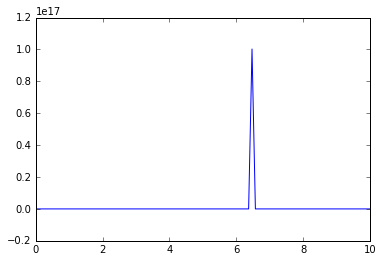

In [71]:
from scipy.integrate import odeint
t_span = np.linspace(0,10,100)
x0 = np.random.randn(2)
x_span = odeint( lambda x,t: np.array( [x[1],x[0]**2]) , x0, t_span)
plt.plot(t_span,x_span[:,0])

In [ ]:
print res.message